In [52]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from utils.tracking_analysis.tracking_plotting import *
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice, beginning_and_end_comparison_mice
from utils.reaction_time_utils import get_bpod_trial_nums_per_session
from utils.post_processing_utils import get_all_experimental_records
from utils.post_processing_utils import remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.behaviour_utils import CalculateRBiasWindow

In [53]:
recording_site = 'tail'

In [78]:
def custom_rolling_mean(data, window_size):
    rolling_means = pd.Series(index=data.index, dtype=float)
    
    for i in range(len(data)):
        # Current trial number
        current_trial_num = data.index[i]
        
        # Define the window's start and end trial numbers
        start_trial_num = current_trial_num - window_size
        
        # Select data within this window range
        window_data = data[(data.index > start_trial_num) & (data.index <= current_trial_num)]
        
        # Only consider data where 'Trial type' matches contra_trial_type
        filtered_window_data = window_data[window_data['Trial type'] == contra_trial_type]
        
        # Check if the window is valid (full 50 trial numbers) and compute the mean
        if window_data.index.max() - window_data.index.min() == window_size - 1:
            rolling_means.iloc[i] = filtered_window_data['choice'].mean()
        else:
            rolling_means.iloc[i] = np.nan
    
    return rolling_means

In [79]:
# Step 3: Function to calculate the rolling mean based on the index and handle shifting
def shift_respecting_index(rolling_mean, shift_size):

    # Shift the rolling mean by the specified number of trials
    shifted_mean = rolling_mean.shift(periods=shift_size)

    # Detect discontinuities in the index
    trial_num_diff = rolling_mean.index.to_series().diff().fillna(shift_size)

    # Identify where the shift should result in NaN due to discontinuities
    discontinuities = trial_num_diff > shift_size
    shifted_mean[discontinuities] = np.nan

    return rolling_mean, shifted_mean



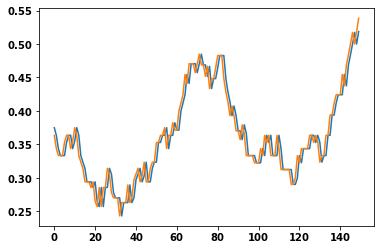

In [82]:
import statsmodels.api as sm
mice = change_over_time_mice[recording_site]
num_lags = 5
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(mice[0:1]):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    filtered_df = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]
    contra_trial_type = filtered_df['Trial type'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

   
    x = 3  # Replace with the actual window size you want


    # Step 2: Convert 'Trial type' to binary
    all_session_data['Trial_type_binary'] = all_session_data['Trial type'].apply(lambda x: 1 if x == contra_trial_type else 0)

   # Step 4: Apply the optimized rolling mean with shift
    rolling_mean = custom_rolling_mean(all_session_data, window_size=50)
    all_session_data['Rolling_mean_choice'], all_session_data['Rolling_mean_choice_shifted'] = shift_respecting_index(
        rolling_mean, shift_size=1)


    # Display the updated DataFrame
    plt.figure()
    plt.plot(all_session_data['Rolling_mean_choice_shifted'].values[50:200])
    plt.plot(rolling_mean.values[50:200])

In [68]:
rolling_mean

actual trial nums
1453.0        NaN
1454.0        NaN
1455.0        NaN
1456.0        NaN
1457.0        NaN
            ...  
11014.0    1.0000
11015.0    0.0625
11016.0    0.0625
11017.0       NaN
11018.0       NaN
Name: choice, Length: 3543, dtype: float64

In [46]:
all_session_data = all_session_data.dropna()

In [ ]:
test_var = 'Rolling_mean_choice'
contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                 & (all_session_data['Trial type'] == contra_trial_type)]
df = contra_trials[['APE_peaks', test_var]]
df[test_var] = df[test_var].astype(float)
df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

df['APE_peaks'] = df['APE_peaks'].astype(float)
df = df.dropna().reset_index(drop=True)


y = df['APE_peaks'].astype(float)
X = df[test_var]
X = sm.add_constant(X)
# Fit the regression model
model = sm.OLS(y, X).fit()
coefs[m, lag-1] = model.params[1:]
print(contra_trials.shape)